In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandas numpy pillow torch torchvision scikit-learn efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 131.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.3 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=974dd7303a1469de551f1ac53e6101f3cfaa3784839c

In [ ]:
# Imports
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
import warnings
import time

warnings.filterwarnings("ignore")

In [ ]:
import os
import zipfile
import torch

# Paths provided by you
ZIP_PATH = '/content/drive/MyDrive/ISIC_2020_Test_Input_resized.zip'
EXTRACT_DIR = '/content/ISIC_2020_Test_Input_resized'  # Temporary extraction location
CSV_PATH = '/content/drive/MyDrive/ISIC_2020_Training_GroundTruth.csv'  # Ground Truth CSV

# Step 1: Extract ZIP only if not extracted before
if not os.path.exists(EXTRACT_DIR):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
        print("Zip extracted successfully.")

# Step 2: Image Directory inside extracted folder
# According to your ZIP structure: 'train/' is the folder containing all images
IMAGE_DIR = os.path.join(EXTRACT_DIR, 'ISIC_2020_Test_Input_resized')

# Check if CSV and images exist
assert os.path.exists(CSV_PATH), "CSV file not found!"
assert os.path.exists(IMAGE_DIR), "Image directory not found!"


# Count only image files with common image extensions
image_extensions = ('.jpg', '.jpeg', '.png')

file_count = len([name for name in os.listdir(IMAGE_DIR)
                  if name.lower().endswith(image_extensions) and os.path.isfile(os.path.join(IMAGE_DIR, name))])

print(f"Number of image files in directory '{IMAGE_DIR}': {file_count}")
# Training Configuration



Zip extracted successfully.
Number of image files in directory '/content/ISIC_2020_Test_Input_resized/ISIC_2020_Test_Input_resized': 33126


In [ ]:
BATCH_SIZE = 2
IMAGE_SIZE = 224
EPOCHS = 1
VERBOSE = True
PRINT_FREQ = 500
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")
print(f"CSV Path: {CSV_PATH}")
print(f"Image Directory: {IMAGE_DIR}")

Using device: cuda
CSV Path: /content/drive/MyDrive/ISIC_2020_Training_GroundTruth.csv
Image Directory: /content/ISIC_2020_Test_Input_resized/ISIC_2020_Test_Input_resized


In [ ]:
# Custom Dataset for JPEG Images
class JPEGDataset(Dataset):
    def __init__(self, dataframe, root_dir=IMAGE_DIR, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx]["image_name"] + ".jpg")  # or .jpeg
        try:
            image = Image.open(img_name).convert("RGB")  # ensure 3-channel RGB
            if self.transform:
                image = self.transform(image)
            label = self.dataframe.iloc[idx]["target"]
            return image, torch.tensor(label, dtype=torch.float32)
        except Exception as e:
            print(f"Error loading {img_name}: {str(e)}")
            dummy_img = torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE)
            return dummy_img, torch.tensor(0.0, dtype=torch.float32)

In [ ]:
def prepare_data_with_test(csv_path, image_dir, test_size=0.1, val_size=0.1):
    df = pd.read_csv(csv_path)
    existing = set(os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith(".jpg"))
    df = df[df["image_name"].isin(existing)]
    df = df[["image_name", "target"]].dropna()

    # Split into test (10%)
    train_val_df, test_df = train_test_split(
        df, test_size=test_size, random_state=42, stratify=df["target"]
    )

    # Split train_val into train/val (10% val of remaining)
    val_frac = val_size / (1 - test_size)
    train_df, val_df = train_test_split(
        train_val_df, test_size=val_frac, random_state=42, stratify=train_val_df["target"]
    )

    print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_ds = JPEGDataset(train_df, root_dir=image_dir, transform=transform)
    val_ds   = JPEGDataset(val_df, root_dir=image_dir, transform=transform)
    test_ds  = JPEGDataset(test_df, root_dir=image_dir, transform=transform)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader, train_val_df, test_df


In [ ]:
# Model Setup
def setup_model():
    model = EfficientNet.from_pretrained("efficientnet-b0")
    model._fc = nn.Linear(model._fc.in_features, 1)
    model = model.to(DEVICE)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    return model, criterion, optimizer


In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader=None):
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        total_samples = 0
        epoch_start = time.time()

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.flatten(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            total_samples += images.size(0)

            if VERBOSE and (batch_idx % PRINT_FREQ == 0 or batch_idx == len(train_loader) - 1):
                print(f"  Batch {batch_idx+1}/{len(train_loader)} | "
                      f"Loss: {loss.item():.4f}")

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {running_loss / total_samples:.4f}")

        # Optional: Validation phase
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(DEVICE), labels.to(DEVICE)
                    outputs = model(images)
                    loss = criterion(outputs.flatten(), labels)
                    val_loss += loss.item() * images.size(0)
            val_loss /= len(val_loader.dataset)
            print(f"  Validation Loss: {val_loss:.4f}")


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [ ]:
from sklearn.metrics import recall_score

def evaluate_model_with_recall(model, loader, true_df):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy().flatten()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy().flatten())

    bin_preds = [1 if p >= 0.5 else 0 for p in all_preds]

    acc = accuracy_score(all_labels, bin_preds)
    auc = roc_auc_score(all_labels, all_preds)
    recall = recall_score(all_labels, bin_preds)

    print(f"\nFinal Test Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Recall: {recall:.4f}")


In [ ]:
%%time
# Split data

from datetime import datetime

# Record start time
overall_start_time = datetime.now()
print(f"\nTraining started at: {overall_start_time.strftime('%Y-%m-%d %H:%M:%S')}")

# Split data
train_loader, val_loader, test_loader, train_val_df, test_df = prepare_data_with_test(CSV_PATH, IMAGE_DIR)

# Step 1: Train model using train/val
step1_start = datetime.now()
print(f"\nStep 1 Training started at: {step1_start.strftime('%Y-%m-%d %H:%M:%S')}")

model, criterion, optimizer = setup_model()
train_model(model, criterion, optimizer, train_loader, val_loader)

step1_end = datetime.now()
print(f"Step 1 Training ended at: {step1_end.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"⏱Step 1 Duration: {step1_end - step1_start}")

# Save model after final training
MODEL_SAVE_PATH = '/content/drive/MyDrive/efficientnet_model_trainonly_resized.pth'
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")



Training started at: 2025-06-27 12:38:58
Train: 26500, Val: 3313, Test: 3313

Step 1 Training started at: 2025-06-27 12:38:59


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 200MB/s]


Loaded pretrained weights for efficientnet-b0
  Batch 1/13250 | Loss: 0.6504
  Batch 501/13250 | Loss: 0.0130
  Batch 1001/13250 | Loss: 0.0130
  Batch 1501/13250 | Loss: 0.0535
  Batch 2001/13250 | Loss: 0.0166
  Batch 2501/13250 | Loss: 0.0134
  Batch 3001/13250 | Loss: 0.0037
  Batch 3501/13250 | Loss: 0.0182
  Batch 4001/13250 | Loss: 0.0100
  Batch 4501/13250 | Loss: 0.0080
  Batch 5001/13250 | Loss: 0.0591
  Batch 5501/13250 | Loss: 0.0123
  Batch 6001/13250 | Loss: 0.0263
  Batch 6501/13250 | Loss: 0.0188
  Batch 7001/13250 | Loss: 0.0179
  Batch 7501/13250 | Loss: 0.0092
  Batch 8001/13250 | Loss: 0.0135
  Batch 8501/13250 | Loss: 0.0386
  Batch 9001/13250 | Loss: 0.0119
  Batch 9501/13250 | Loss: 0.0053
  Batch 10001/13250 | Loss: 0.0089
  Batch 10501/13250 | Loss: 0.0118
  Batch 11001/13250 | Loss: 0.0235
  Batch 11501/13250 | Loss: 0.9677
  Batch 12001/13250 | Loss: 0.0048
  Batch 12501/13250 | Loss: 0.0063
  Batch 13001/13250 | Loss: 0.0297
  Batch 13250/13250 | Loss: 0.004

In [ ]:
# Step 3: Evaluate on test set
from sklearn.metrics import accuracy_score, roc_auc_score
evaluate_model_with_recall(model, test_loader, test_df)


Final Test Results:
Accuracy: 0.9825
AUC: 0.8061
Recall: 0.0000



Creating comprehensive visualizations...
Evaluating model and collecting predictions...
  Processed batch 1/1657
  Processed batch 51/1657
  Processed batch 101/1657
  Processed batch 151/1657
  Processed batch 201/1657
  Processed batch 251/1657
  Processed batch 301/1657
  Processed batch 351/1657
  Processed batch 401/1657
  Processed batch 451/1657
  Processed batch 501/1657
  Processed batch 551/1657
  Processed batch 601/1657
  Processed batch 651/1657
  Processed batch 701/1657
  Processed batch 751/1657
  Processed batch 801/1657
  Processed batch 851/1657
  Processed batch 901/1657
  Processed batch 951/1657
  Processed batch 1001/1657
  Processed batch 1051/1657
  Processed batch 1101/1657
  Processed batch 1151/1657
  Processed batch 1201/1657
  Processed batch 1251/1657
  Processed batch 1301/1657
  Processed batch 1351/1657
  Processed batch 1401/1657
  Processed batch 1451/1657
  Processed batch 1501/1657
  Processed batch 1551/1657
  Processed batch 1601/1657
  Processe

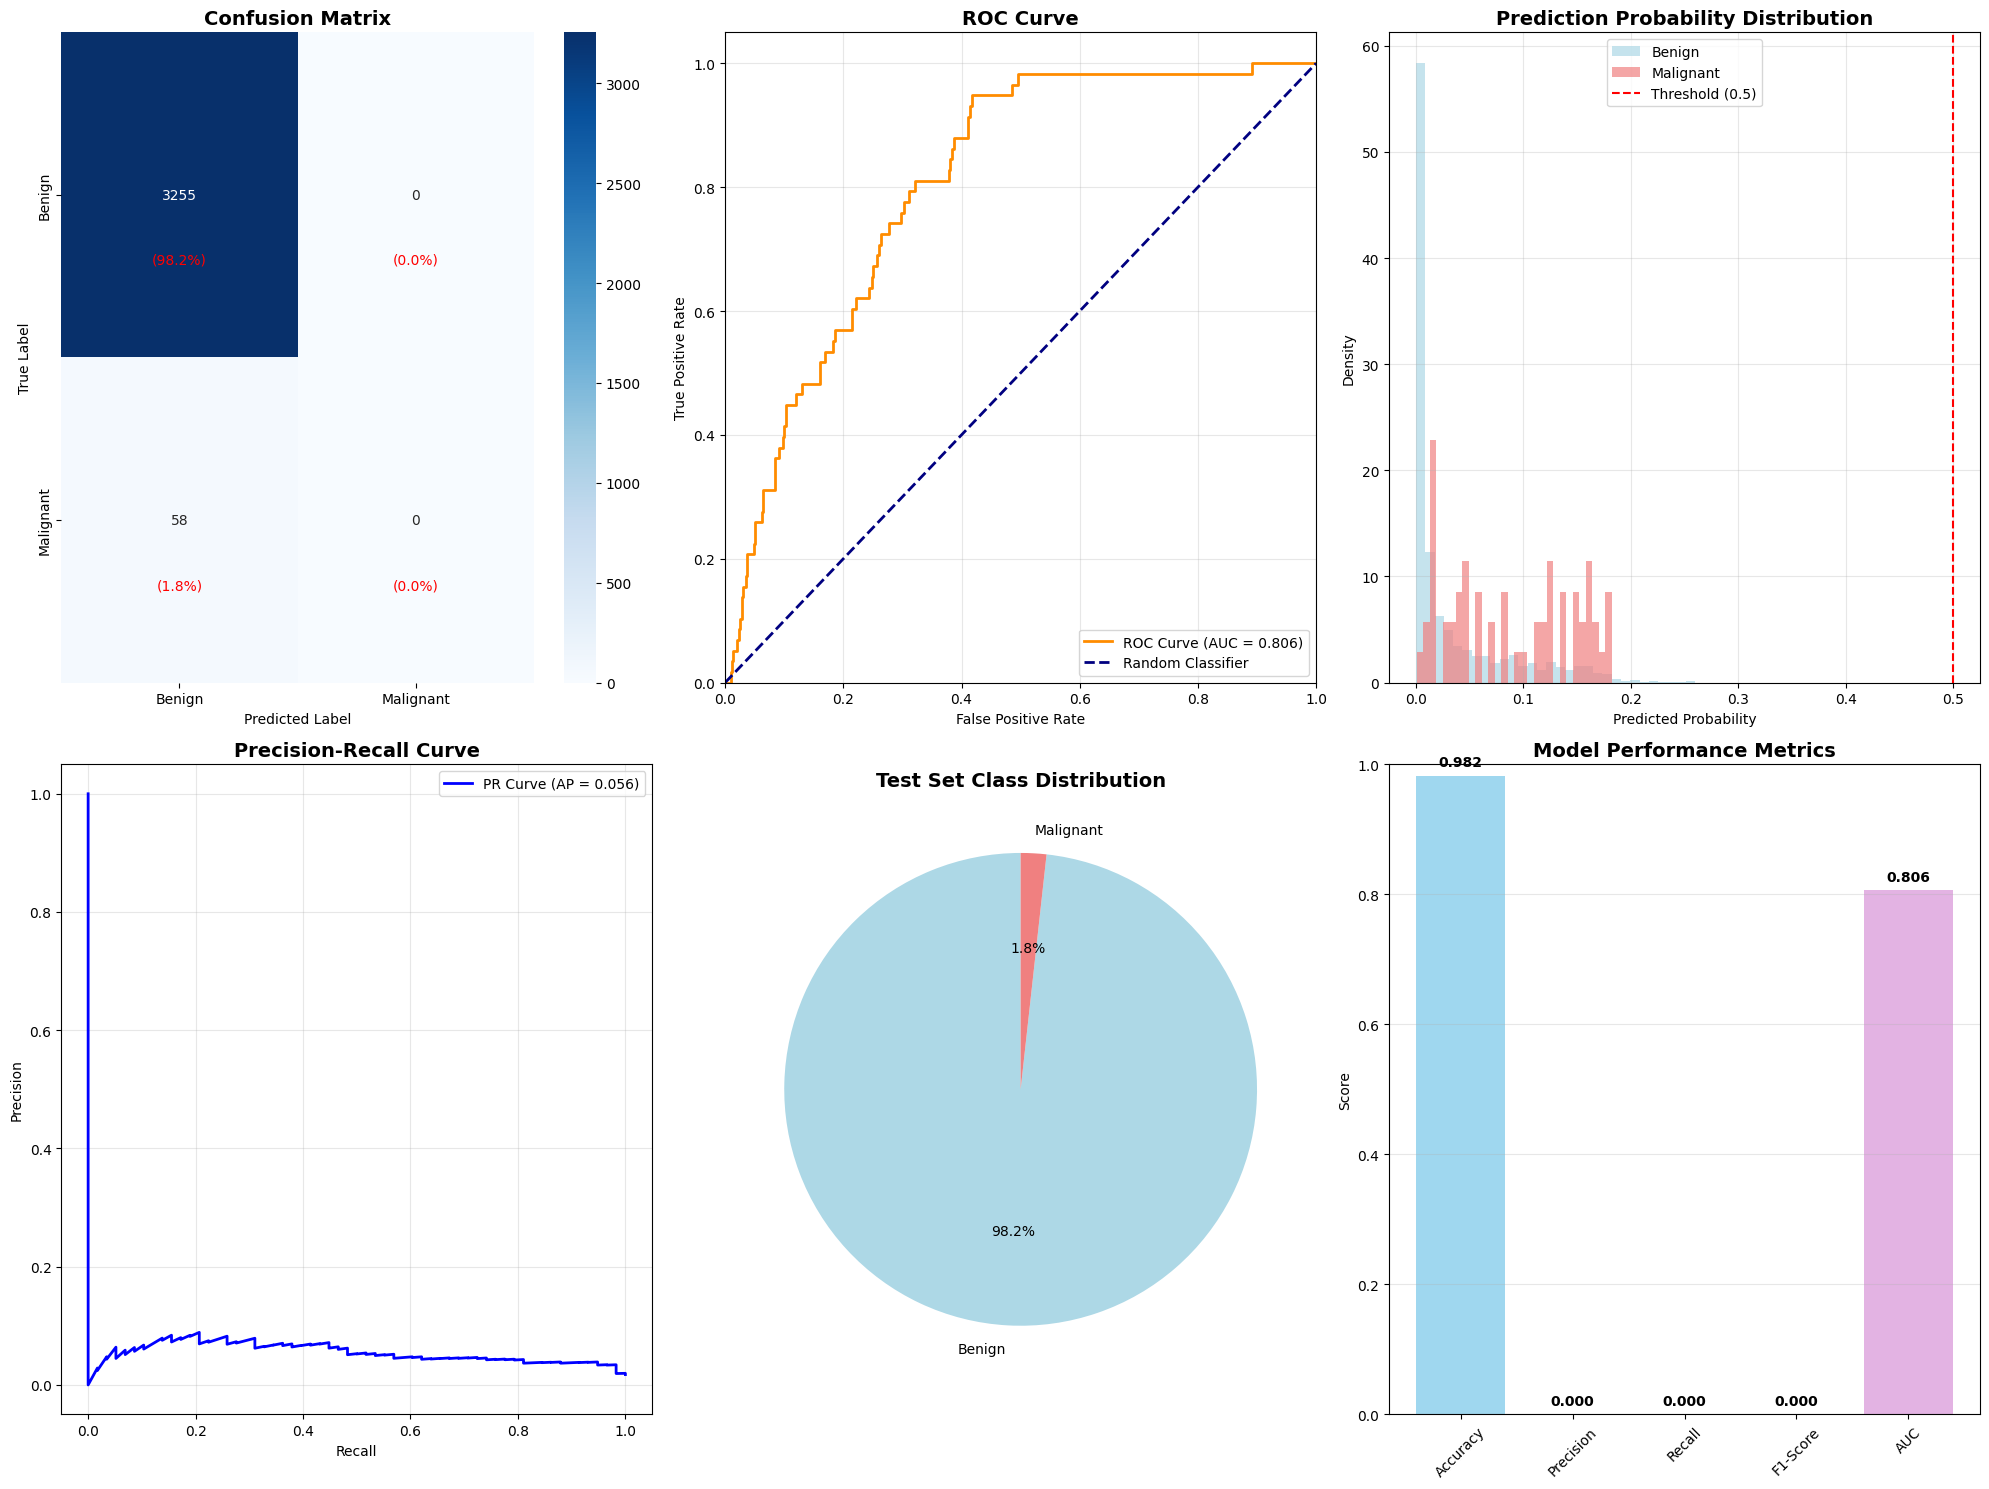


Detailed Classification Report:
              precision    recall  f1-score   support

      Benign     0.9825    1.0000    0.9912      3255
   Malignant     0.0000    0.0000    0.0000        58

    accuracy                         0.9825      3313
   macro avg     0.4912    0.5000    0.4956      3313
weighted avg     0.9653    0.9825    0.9738      3313


Confusion Matrix Breakdown:
True Negatives (TN):  3255
False Positives (FP): 0
False Negatives (FN): 58
True Positives (TP):  0

Sensitivity (TPR): 0.0000
Specificity (TNR): 1.0000
False Positive Rate: 0.0000
False Negative Rate: 1.0000

Evaluation complete! Results saved and displayed.
Total test samples: 3313
Model achieved 98.2% accuracy on test set


In [ ]:
# Enhanced Model Evaluation with Visualizations and Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np

def evaluate_model_with_visualizations(model, loader, true_df, save_path=None):
    """
    Enhanced evaluation function with comprehensive visualizations
    """
    model.eval()
    all_preds, all_labels = [], []
    all_probs = []  # Store probabilities for ROC curve

    print("Evaluating model and collecting predictions...")

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images = images.to(DEVICE)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()

            all_probs.extend(probs)
            all_labels.extend(labels.numpy().flatten())

            # Progress indicator
            if batch_idx % 50 == 0:
                print(f"  Processed batch {batch_idx+1}/{len(loader)}")

    # Convert to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Binary predictions using 0.5 threshold
    bin_preds = (all_probs >= 0.5).astype(int)

    # Calculate metrics
    from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score

    acc = accuracy_score(all_labels, bin_preds)
    auc_score = roc_auc_score(all_labels, all_probs)
    recall = recall_score(all_labels, bin_preds)
    precision = precision_score(all_labels, bin_preds)
    f1 = f1_score(all_labels, bin_preds)

    print(f"\nFinal Test Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"AUC: {auc_score:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Create comprehensive visualizations
    fig = plt.figure(figsize=(20, 15))

    # 1. Confusion Matrix
    plt.subplot(2, 3, 1)
    cm = confusion_matrix(all_labels, bin_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add percentages to confusion matrix
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            plt.text(j+0.5, i+0.7, f'({cm[i,j]/total*100:.1f}%)',
                    ha='center', va='center', fontsize=10, color='red')

    # 2. ROC Curve
    plt.subplot(2, 3, 2)
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    # 3. Prediction Distribution
    plt.subplot(2, 3, 3)
    benign_probs = all_probs[all_labels == 0]
    malignant_probs = all_probs[all_labels == 1]

    plt.hist(benign_probs, bins=30, alpha=0.7, label='Benign', color='lightblue', density=True)
    plt.hist(malignant_probs, bins=30, alpha=0.7, label='Malignant', color='lightcoral', density=True)
    plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Precision-Recall Curve
    plt.subplot(2, 3, 4)
    from sklearn.metrics import precision_recall_curve, average_precision_score

    precision_vals, recall_vals, pr_thresholds = precision_recall_curve(all_labels, all_probs)
    avg_precision = average_precision_score(all_labels, all_probs)

    plt.plot(recall_vals, precision_vals, color='blue', lw=2,
             label=f'PR Curve (AP = {avg_precision:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 5. Class Distribution
    plt.subplot(2, 3, 5)
    class_counts = [np.sum(all_labels == 0), np.sum(all_labels == 1)]
    colors = ['lightblue', 'lightcoral']
    plt.pie(class_counts, labels=['Benign', 'Malignant'], autopct='%1.1f%%',
            colors=colors, startangle=90)
    plt.title('Test Set Class Distribution', fontsize=14, fontweight='bold')

    # 6. Metrics Bar Chart
    plt.subplot(2, 3, 6)
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
    values = [acc, precision, recall, f1, auc_score]
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'khaki', 'plum']

    bars = plt.bar(metrics, values, color=colors, alpha=0.8)
    plt.ylim(0, 1)
    plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
    plt.ylabel('Score')

    # Add value labels on bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()

    # Save the plot if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualizations saved to: {save_path}")

    plt.show()

    # Print detailed classification report
    print(f"\nDetailed Classification Report:")
    print("=" * 50)
    print(classification_report(all_labels, bin_preds,
                              target_names=['Benign', 'Malignant'],
                              digits=4))

    # Print confusion matrix details
    print(f"\nConfusion Matrix Breakdown:")
    print("=" * 30)
    tn, fp, fn, tp = cm.ravel()
    print(f"True Negatives (TN):  {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP):  {tp}")
    print(f"\nSensitivity (TPR): {tp/(tp+fn):.4f}")
    print(f"Specificity (TNR): {tn/(tn+fp):.4f}")
    print(f"False Positive Rate: {fp/(fp+tn):.4f}")
    print(f"False Negative Rate: {fn/(fn+tp):.4f}")

    return {
        'accuracy': acc,
        'auc': auc_score,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'confusion_matrix': cm,
        'probabilities': all_probs,
        'labels': all_labels,
        'predictions': bin_preds
    }

# Run the enhanced evaluation
print("\nCreating comprehensive visualizations...")
viz_save_path = '/content/drive/MyDrive/model_evaluation_results_resized.png'

# Replace your existing evaluate_model call with this:
results = evaluate_model_with_visualizations(model, test_loader, test_df, save_path=viz_save_path)

print(f"\nEvaluation complete! Results saved and displayed.")
print(f"Total test samples: {len(results['labels'])}")
print(f"Model achieved {results['accuracy']:.1%} accuracy on test set")

In [ ]:
# %%time
# from datetime import datetime
# import torch

# # Record start time for epoch 2
# epoch2_start_time = datetime.now()
# print(f"\nEpoch 2 Training started at: {epoch2_start_time.strftime('%Y-%m-%d %H:%M:%S')}")

# # Path to the saved epoch 1 model
# EPOCH1_MODEL_PATH = '/content/drive/MyDrive/efficientnet_model_trainonly_resized.pth'

# # Load the epoch 1 trained model
# print("Loading epoch 1 model...")
# model, criterion, optimizer = setup_model()
# model.load_state_dict(torch.load(EPOCH1_MODEL_PATH))
# print("Epoch 1 model loaded successfully")

# # Prepare data (same as epoch 1)
# print("Preparing data...")
# train_loader, val_loader, test_loader, train_val_df, test_df = prepare_data_with_test(CSV_PATH, IMAGE_DIR)

# # Continue training for epoch 2
# print("Starting epoch 2 training...")
# epoch2_training_start = datetime.now()
# print(f"Epoch 2 training started at: {epoch2_training_start.strftime('%Y-%m-%d %H:%M:%S')}")

# # Train the model (this will continue from where epoch 1 left off)
# train_model(model, criterion, optimizer, train_loader, val_loader)

# epoch2_training_end = datetime.now()
# print(f"Epoch 2 training ended at: {epoch2_training_end.strftime('%Y-%m-%d %H:%M:%S')}")
# print(f"Epoch 2 training duration: {epoch2_training_end - epoch2_training_start}")

# # Save the epoch 2 model
# EPOCH2_MODEL_PATH = '/content/drive/MyDrive/efficientnet_model_epoch2_resized.pth'
# torch.save(model.state_dict(), EPOCH2_MODEL_PATH)
# print(f"Epoch 2 model saved to {EPOCH2_MODEL_PATH}")

# # Calculate total time for epoch 2 process
# epoch2_end_time = datetime.now()
# print(f"Total epoch 2 process duration: {epoch2_end_time - epoch2_start_time}")
# print(f"Epoch 2 process completed at: {epoch2_end_time.strftime('%Y-%m-%d %H:%M:%S')}")


Epoch 2 Training started at: 2025-06-20 06:48:55
Loading epoch 1 model...
Loaded pretrained weights for efficientnet-b0
Epoch 1 model loaded successfully
Preparing data...
Train: 26500, Val: 3313, Test: 3313
Starting epoch 2 training...
Epoch 2 training started at: 2025-06-20 06:48:55
  Batch 1/13250 | Loss: 0.0031
  Batch 501/13250 | Loss: 0.0099
  Batch 1001/13250 | Loss: 0.0404
  Batch 1501/13250 | Loss: 0.0083
  Batch 2001/13250 | Loss: 0.0336
  Batch 2501/13250 | Loss: 0.0084
  Batch 3001/13250 | Loss: 0.0527
  Batch 3501/13250 | Loss: 0.0061
  Batch 4001/13250 | Loss: 0.0059
  Batch 4501/13250 | Loss: 0.0088
  Batch 5001/13250 | Loss: 0.0158
  Batch 5501/13250 | Loss: 0.0238
  Batch 6001/13250 | Loss: 0.0139
  Batch 6501/13250 | Loss: 0.0120
  Batch 7001/13250 | Loss: 0.0290
  Batch 7501/13250 | Loss: 0.0129
  Batch 8001/13250 | Loss: 0.0056
  Batch 8501/13250 | Loss: 0.0061
  Batch 9001/13250 | Loss: 0.0071
  Batch 9501/13250 | Loss: 0.0058
  Batch 10001/13250 | Loss: 0.0105
  

In [ ]:
# # Step 3: Evaluate epoch 2 model on test set
# from sklearn.metrics import accuracy_score, roc_auc_score

# print("Evaluating epoch 2 model on test set...")
# print(f"Model being evaluated: Epoch 2 trained model")

# # Evaluate the epoch 2 model (currently loaded in 'model' variable)
# evaluate_model_with_recall(model, test_loader, test_df)

# # Optional: If you want to compare with epoch 1 model
# # Uncomment below to also evaluate epoch 1 model for comparison

# print("\nFor comparison, evaluating epoch 1 model...")
# epoch1_model, _, _ = setup_model()
# epoch1_model.load_state_dict(torch.load('/content/drive/MyDrive/efficientnet_model_trainonly_resized.pth'))
# evaluate_model_with_recall(epoch1_model, test_loader, test_df)


Evaluating epoch 2 model on test set...
Model being evaluated: Epoch 2 trained model

Final Test Results:
Accuracy: 0.9825
AUC: 0.8369
Recall: 0.0000

For comparison, evaluating epoch 1 model...
Loaded pretrained weights for efficientnet-b0

Final Test Results:
Accuracy: 0.9825
AUC: 0.7397
Recall: 0.0000
